In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
from utils import translate_sentence, check_convergence, evaluate, train, plot_losses_bleu
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152
import os
import numpy as np
import random
import math
import sys

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Vocabulary Class

In [2]:
import re
from data_loader import DataLoader

# Create a Vocab object from the vocab list
class Vocabulary:
    def __init__(self, vocab_list):
        self.vocab_list = vocab_list
        # Add " " to the vocab list
        self.vocab_list.append(' ')

        # Add special tokens
        self.vocab_list.insert(0, '<pad>')
        self.vocab_list.insert(1, '<sos>')
        self.vocab_list.insert(2, '<eos>')
        self.vocab_list.insert(3, '<unk>')

        self.id2token = {i: t for i, t in enumerate(self.vocab_list)}
        self.token2id = {t: i for i, t in self.id2token.items()}

        self.pad_idx = self.token2id['<pad>']
        self.sos_idx = self.token2id['<sos>']
        self.eos_idx = self.token2id['<eos>']
        self.unk_idx = self.token2id['<unk>']

    def __len__(self):
        return len(self.vocab_list)
    
    # Overwrite the indexing operator
    def __getitem__(self, index):
        return self.vocab_list[index]

    def id2string(self, ids):
        # Select a subset from self.sos_idx to self.eos_idx
        if self.eos_idx in ids:
            ids = ids[:ids.index(self.eos_idx)]
        if self.sos_idx in ids:
            ids = ids[ids.index(self.sos_idx)+1:]

        tokens = [self.id2token[id] for id in ids]
        return tokens

    # Tokenize the formula
    def split_string_by_tokens(self, string, max_length):
        max_length = max_length - 1
        # Sort the vocabulary by length in descending order
        vocab = sorted(self.vocab_list, key=len, reverse=True)

        # Generate a regular expression pattern that matches any of the vocabulary words
        pattern = "|".join(re.escape(word) for word in vocab)
        
        # Use the pattern to split the string into tokens
        tokens = re.findall(pattern, string)
        
        # Add unknown tokens for any characters not matched by the pattern
        str_index = 0
        updated_tokens = []
        i = 0
        while i < (len(tokens)):
            cur_token = tokens[i]
            if string[str_index:str_index+len(cur_token)] == cur_token:
                updated_tokens.append(cur_token)
                str_index += len(cur_token)
                i += 1
            else:
                updated_tokens.append(f"<unk>")
                str_index += 1

        if str_index != len(string):
            for i in range(len(string) - str_index):
                updated_tokens.append(f"<unk>") 

        # Append <eos> token
        updated_tokens.append('<eos>')

        if len(updated_tokens) > max_length:
            updated_tokens = updated_tokens[:max_length]
        else:
            for i in range(max_length - len(updated_tokens)):
                updated_tokens.append('<pad>')
        
        # Insert <sos> token
        updated_tokens.insert(0, '<sos>')

        # Convert tokens to indices
        # indexed_tokens = updated_tokens
        indexed_tokens = [self.token2id[token] for token in updated_tokens]

        return indexed_tokens

## Model Architecture

In [3]:
class SelfAttention(nn.Module):
    """
    A self-attention module for a transformer-based neural machine translation model.

    Args:
        embed_size: an integer representing the size of the token embeddings.
        heads: an integer representing the number of heads to use in the multi-head attention layer.
    """
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()

        # set instance variables
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        # make sure embed_size is divisible by heads
        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"

        # initialize linear layers
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        """
        Applies self-attention to the input sequences.

        Args:
            values: a PyTorch tensor of shape (N, value_len, embed_size) representing the values to be used in attention.
            keys: a PyTorch tensor of shape (N, key_len, embed_size) representing the keys to be used in attention.
            query: a PyTorch tensor of shape (N, query_len, embed_size) representing the queries to be used in attention.
            mask: a PyTorch tensor of shape (N, 1, key_len) representing the mask to be applied to the attention scores.

        Returns:
            A PyTorch tensor of shape (N, query_len, embed_size) representing the output of the self-attention layer.
        """
        # get batch size
        N = query.shape[0]

        # get sequence lengths
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # split embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim) # (N, value_len, heads, head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)       # (N, key_len, heads, head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim) # (N, query_len, heads, head_dim)

        # apply linear transformations
        values = self.values(values) # (N, value_len, heads, head_dim)
        keys = self.keys(keys)       # (N, key_len, heads, head_dim)
        queries = self.queries(queries) # (N, query_len, heads, head_dim)

        # compute attention scores
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys]) # (N, heads, query_len, key_len)
        
        if mask is not None:
            # mask out positions with padding tokens
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # apply softmax and normalize by key_len
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) # (N, heads, query_len, key_len)

        # compute output using attention scores
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        ) # (N, query_len, heads * head_dim)

        # apply final linear transformation
        out = self.fc_out(out) # (N, query_len, embed_size)

        return out

class TransformerBlock(nn.Module):
    """
    A single Transformer block with self-attention and feedforward layers.

    Args:
        embed_size (int): Size of the input and output embeddings.
        heads (int): Number of attention heads to use.
        dropout (float): Dropout rate to apply.
        forward_expansion (int): Size of the hidden layer in the feedforward network.

    Inputs:
        value (torch.Tensor): Input tensor of shape (N, value_len, embed_size).
        key (torch.Tensor): Input tensor of shape (N, key_len, embed_size).
        query (torch.Tensor): Input tensor of shape (N, query_len, embed_size).
        mask (torch.Tensor): Mask tensor of shape (N, query_len, key_len).

    Returns:
        torch.Tensor: Output tensor of shape (N, query_len, embed_size).
    """
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()

        # initialize self-attention, normalization, and feed forward layers
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        # initialize dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        """
        Forward pass for a single Transformer block.

        Args:
            value (torch.Tensor): Input tensor of shape (N, value_len, embed_size).
            key (torch.Tensor): Input tensor of shape (N, key_len, embed_size).
            query (torch.Tensor): Input tensor of shape (N, query_len, embed_size).
            mask (torch.Tensor): Mask tensor of shape (N, query_len, key_len).

        Returns:
            torch.Tensor: Output tensor of shape (N, query_len, embed_size).
        """
        # apply self-attention layer
        attention = self.attention(value, key, query, mask) # (N, query_len, embed_size)

        # add skip connection, run through normalization and then dropout
        x = self.dropout(self.norm1(attention + query)) # (N, query_len, embed_size)

        # pass through feed forward network
        forward = self.feed_forward(x) # (N, query_len, embed_size)

        # add skip connection, run through normalization and then dropout
        out = self.dropout(self.norm2(forward + x)) # (N, query_len, embed_size)

        return out

class Encoder(nn.Module):
    """
    A CNN-based encoder that extracts features from input images and adds positional encodings.

    Args:
        in_channels (int, optional): Number of input channels. Default is 1 for grayscale images.
        embed_size (int, optional): Size of the output embeddings. Default is 512.
        resnet_type (int, optional): Type of the ResNet model to use. Options are 18, 34, 50, 101, and 152.
                                      Default is 34.
        max_positional_encoding (int, optional): Maximum length of the positional encoding. Default is 1000.

    Inputs:
        x (torch.Tensor): Input tensor of shape (N, in_channels, H, W).

    Returns:
        torch.Tensor: Output tensor of shape (N, H/32 * W/32, embed_size).
    """
    def __init__(self, in_channels=1, embed_size=512, resnet_type=34, max_positional_encoding=1000):
        super(Encoder, self).__init__()

        # Load the pretrained ResNet model based on the resnet_type parameter
        if resnet_type == 18:
            resnet = resnet18(pretrained=True)
        elif resnet_type == 34:
            resnet = resnet34(pretrained=True)
        elif resnet_type == 50:
            resnet = resnet50(pretrained=True)
        elif resnet_type == 101:
            resnet = resnet101(pretrained=True)
        elif resnet_type == 152:
            resnet = resnet152(pretrained=True)
        else:
            raise ValueError("Invalid resnet_type. Options are 18, 34, 50, 101, and 152.")

        # Modify the first convolutional layer to accept single-channel input
        resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Remove the last two layers (avgpool and fc)
        self.cnn_encoder = nn.Sequential(*list(resnet.children())[:-2])

        # Add a 1x1 convolutional layer to adjust the number of channels if needed
        if resnet.fc.in_features != embed_size:
            self.channel_adjustment = nn.Conv2d(resnet.fc.in_features, embed_size, kernel_size=1)
        else:
            self.channel_adjustment = None

        # Initialize positional encoding
        self.register_buffer("positional_encoding", self.get_positional_encoding(max_positional_encoding, embed_size))

    def get_positional_encoding(self, max_length, embed_size):
        """
        Generates a positional encoding matrix.

        Args:
            max_length (int): Maximum length of the positional encoding.
            embed_size (int): Size of the embeddings.

        Returns:
            torch.Tensor: Positional encoding tensor of shape (1, max_length, embed_size).
        """
        # Generate positional encoding
        pos_enc = torch.zeros(max_length, embed_size)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.pow(10000, torch.arange(0, embed_size, 2).float() / embed_size)
        pos_enc[:, 0::2] = torch.sin(position / div_term)
        pos_enc[:, 1::2] = torch.cos(position / div_term)
        pos_enc = pos_enc.unsqueeze(0)
        return pos_enc

    def forward(self, x):
        """
        Forward pass of the encoder.

        Args:
            x (torch.Tensor): Input tensor of shape (N, in_channels, H, W).

        Returns:
            torch.Tensor: Output tensor of shape (N, H/32 * W/32, embed_size).
        """
        # Pass the input image through the CNN encoder
        features = self.cnn_encoder(x) # (N, output_channels, H/32, W/32)

        # Adjust the number of channels if needed
        if self.channel_adjustment is not None:
            features = self.channel_adjustment(features)

        features = features.view(features.size(0), features.size(1), -1) # (N, output_channels, H/32 * W/32)
        features = features.permute(0, 2, 1) # (N, H/32 * W/32, output_channels)

        # Add positional encodings
        positions = self.positional_encoding[:, :features.size(1), :] # (1, query_len, embed_size)
        features = features + positions # (N, query_len, embed_size)

        return features # (N, query_len, embed_size)

class DecoderBlock(nn.Module):
    """
    A single decoder block that uses self-attention and a transformer block to process decoder inputs.

    Args:
        embed_size (int): Size of the input and output embeddings.
        heads (int): Number of attention heads to use.
        forward_expansion (int): Size of the hidden layer in the feedforward network in the transformer block.
        dropout (float): Dropout rate to apply.
        device (str): Device to use for computations.

    Inputs:
        x (torch.Tensor): Input tensor of shape (N, trg_len, embed_size).
        value (torch.Tensor): Input tensor of shape (N, src_len, embed_size).
        key (torch.Tensor): Input tensor of shape (N, src_len, embed_size).
        src_mask (torch.Tensor): Mask tensor of shape (N, 1, src_len).
        trg_mask (torch.Tensor): Mask tensor of shape (N, trg_len, trg_len).

    Returns:
        torch.Tensor: Output tensor of shape (N, trg_len, embed_size).
    """
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()

        # Initialize self-attention, normalization, and transformer block layers
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )

        # Initialize dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        """
        Forward pass of the decoder block.

        Args:
            x (torch.Tensor): Input tensor of shape (N, trg_len, embed_size).
            value (torch.Tensor): Input tensor of shape (N, src_len, embed_size).
            key (torch.Tensor): Input tensor of shape (N, src_len, embed_size).
            src_mask (torch.Tensor): Mask tensor of shape (N, 1, src_len).
            trg_mask (torch.Tensor): Mask tensor of shape (N, trg_len, trg_len).

        Returns:
            torch.Tensor: Output tensor of shape (N, trg_len, embed_size).
        """
        # Self-attention layer
        attention = self.attention(x, x, x, trg_mask) # (N, trg_len, embed_size)

        # Add skip connection, run through normalization and then dropout
        query = self.dropout(self.norm(attention + x)) # (N, trg_len, embed_size)

        # Transformer block layer
        out = self.transformer_block(value, key, query, src_mask) # (N, trg_len, embed_size)

        return out

class Decoder(nn.Module):
    """
    The decoder of the Transformer model that uses multiple decoder blocks to generate the target sequence.

    Args:
        trg_vocab_size (int): Size of the target vocabulary.
        embed_size (int): Size of the input and output embeddings.
        num_layers (int): Number of decoder blocks to use.
        heads (int): Number of attention heads to use.
        forward_expansion (int): Size of the hidden layer in the feedforward network in each decoder block.
        dropout (float): Dropout rate to apply.
        device (str): Device to use for computations.
        max_length (int): Maximum length of the positional encoding.

    Inputs:
        x (torch.Tensor): Input tensor of shape (N, seq_length).
        enc_out (torch.Tensor): Output tensor of the encoder of shape (N, src_seq_length, embed_size).
        src_mask (torch.Tensor): Mask tensor for the source sequence of shape (N, 1, src_seq_length).
        trg_mask (torch.Tensor): Mask tensor for the target sequence of shape (N, seq_length, seq_length).

    Returns:
        torch.Tensor: Output tensor of shape (N, seq_length, trg_vocab_size).
    """
    def __init__(
            self,
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length
        ):
        super(Decoder, self).__init__()

        # Initialize word embedding layer
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)

        # Initialize decoder blocks
        self.layers = nn.ModuleList(
            [DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
             for _ in range(num_layers)]
        )

        # Initialize output linear layer
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)

        # Initialize dropout layer
        self.dropout = nn.Dropout(dropout)

        # Initialize positional encoding
        self.register_buffer("positional_encoding", self.get_positional_encoding(max_length, embed_size))
    
    def get_positional_encoding(self, max_length, embed_size):
        """
        Generates a positional encoding matrix.

        Args:
            max_length (int): Maximum length of the positional encoding.
            embed_size (int): Size of the embeddings.

        Returns:
            torch.Tensor: Positional encoding tensor of shape (1, max_length, embed_size).
        """
        # Generate positional encoding
        pos_enc = torch.zeros(max_length, embed_size)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.pow(10000, torch.arange(0, embed_size, 2).float() / embed_size)
        pos_enc[:, 0::2] = torch.sin(position / div_term)
        pos_enc[:, 1::2] = torch.cos(position / div_term)
        pos_enc = pos_enc.unsqueeze(0)
        return pos_enc

    def forward(self, x, enc_out, src_mask, trg_mask):
        """
        Forward pass of the decoder.

        Args:
            x (torch.Tensor): Input tensor of shape (N, seq_length).
            enc_out (torch.Tensor): Output tensor of the encoder of shape (N, src_seq_length, embed_size).
            src_mask (torch.Tensor): Mask tensor for the source sequence of shape (N, 1, src_seq_length).
            trg_mask (torch.Tensor): Mask tensor for the target sequence of shape (N, seq_length, seq_length).

        Returns:
            torch.Tensor: Output tensor of shape (N, seq_length, trg_vocab_size).
        """
        N, seq_length = x.shape

        # Add word embeddings
        x = self.word_embedding(x) # (N, seq_length, embed_size)

        # Add positional encodings
        positions = self.positional_encoding[:, :seq_length, :] # (1, seq_length, embed_size)
        x = self.dropout(x + positions) # (N, seq_length, embed_size)

        # Pass through transformer blocks
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask) # (N, seq_length, embed_size)

        # Pass through output linear layer
        out = self.fc_out(x) # (N, seq_length, trg_vocab_size)

        return out

class Transformer(nn.Module):
    """
    The Transformer model that uses an encoder and decoder to generate the target sequence.

    Args:
        trg_vocab_size (int): Size of the target vocabulary.
        trg_pad_idx (int): Index of the target padding token.
        embed_size (int): Size of the input and output embeddings.
        resnet_type (int): Type of ResNet to use for the encoder.
        num_layers (int): Number of decoder blocks to use.
        forward_expansion (int): Size of the hidden layer in the feedforward network in each decoder block.
        heads (int): Number of attention heads to use.
        dropout (float): Dropout rate to apply.
        device (str): Device to use for computations.
        max_length (int): Maximum length of the positional encoding.

    Inputs:
        src (torch.Tensor): Input tensor of shape (N, src_seq_length).
        trg (torch.Tensor): Target tensor of shape (N, trg_seq_length).

    Returns:
        torch.Tensor: Output tensor of shape (N, trg_seq_length, trg_vocab_size).
    """
    def __init__(
            self,
            trg_vocab_size,
            trg_pad_idx,
            embed_size=512,
            resnet_type=34,
            num_layers=6,
            forward_expansion=4,
            heads=8,
            dropout=0,
            device="cuda",
            max_length=200
        ):
        super(Transformer, self).__init__()

        # Initialize hyperparameters
        self.embed_size = embed_size
        self.resnet_type = resnet_type
        self.num_layers = num_layers
        self.forward_expansion = forward_expansion
        self.heads = heads
        self.dropout = dropout
        self.device = device
        self.max_length = max_length

        # Initialize encoder and decoder
        self.encoder = Encoder(
            in_channels=1,
            embed_size=embed_size,
            resnet_type=resnet_type,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        # Store padding index and device
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    
    def make_trg_mask(self, trg):
        """
        Creates a target mask for the decoder.

        Args:
            trg (torch.Tensor): Target caption tensor of shape (N, trg_len).

        Returns:
            torch.Tensor: Target mask tensor of shape (N, 1, trg_len, trg_len).
        """
        # Create target mask
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        ) # (N, 1, trg_len, trg_len)
        return trg_mask.to(self.device)
    
    def forward(self, src, trg):
        """
        Forward pass of the transformer model.

        Args:
            src (torch.Tensor): Source image tensor of shape (N, C, H, W).
            trg (torch.Tensor): Target caption tensor of shape (N, trg_len).

        Returns:
            torch.Tensor: Predicted caption tensor of shape (N, trg_len, trg_vocab_size).
        """
        # Create masks
        src_mask = None
        trg_mask = self.make_trg_mask(trg) # (N, 1, trg_len, trg_len)

        # Pass through encoder
        enc_src = self.encoder(src) # (N, query_len, embed_size)

        # Pass through decoder
        out = self.decoder(trg, enc_src, src_mask, trg_mask) # (N, trg_len, trg_vocab_size)

        return out


## Data Loader

In [4]:
# Import necessary libraries
import torch
from torchvision import transforms

# Open vocab.txt and load each line into a list, remove new line character
with open('processed_data/vocab.txt', 'r', encoding='windows-1252') as f:
    vocab_list = [line.strip() for line in f.readlines()]
latex_vocab = Vocabulary(vocab_list)
print('Vocab size: {}'.format(len(latex_vocab.vocab_list)))

# Set parameters
batch_size = 16
vocab_size = len(vocab_list)
max_token_length = 200

# Create a transform for binary images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load training, validation, and test data
train_data = DataLoader('processed_data/train_all', 'processed_data/train_formulas_all.txt', latex_vocab, transform, max_token_length)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

validation_data = DataLoader('processed_data/validation_all', 'processed_data/validation_formulas_all.txt', latex_vocab, transform, max_token_length)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=0)

test_data = DataLoader('processed_data/test_all', 'processed_data/test_formulas_all.txt', latex_vocab, transform, max_token_length)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

# Print file names for the first 5 samples in train_data
for i in range(5):
    image, formula_idx, fname = train_data[i]
    print(fname)


Vocab size: 533
Number of images: 82828
Number of im2formula mappings: 82828
Number of images: 10353
Number of im2formula mappings: 10353
Number of images: 10355
Number of im2formula mappings: 10355
60ee748793.png
1cbb05a562.png
ed164cc822.png
e265f9dc6b.png
72f6bc494a.png


### Check Data Loader Working

Length of dataset: 82828
308e3ebcf5.png
Label: G_{ab}^{(1)} = \left\{ \begin{array}{ll} 0 & \mbox{for $a,b\ne i,j$} \\ f_if_j+k_{ij}+\delta_{ij}A\rho & \mbox{for $a,b= i,j$} \end{array}\right.
Token Idxs: [1, 56, 495, 528, 497, 498, 530, 494, 528, 8, 30, 9, 530, 532, 46, 532, 272, 532, 146, 528, 510, 510, 530, 532, 24, 532, 6, 532, 291, 498, 514, 525, 528, 503, 514, 518, 532, 19, 497, 12, 498, 318, 532, 506, 12, 508, 19, 530, 532, 128, 532, 503, 495, 506, 503, 495, 508, 11, 509, 495, 528, 506, 508, 530, 11, 194, 495, 528, 506, 508, 530, 50, 380, 532, 6, 532, 291, 498, 514, 525, 528, 503, 514, 518, 532, 19, 497, 12, 498, 46, 532, 506, 12, 508, 19, 530, 532, 206, 382, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokens: ['<sos>', 'G',

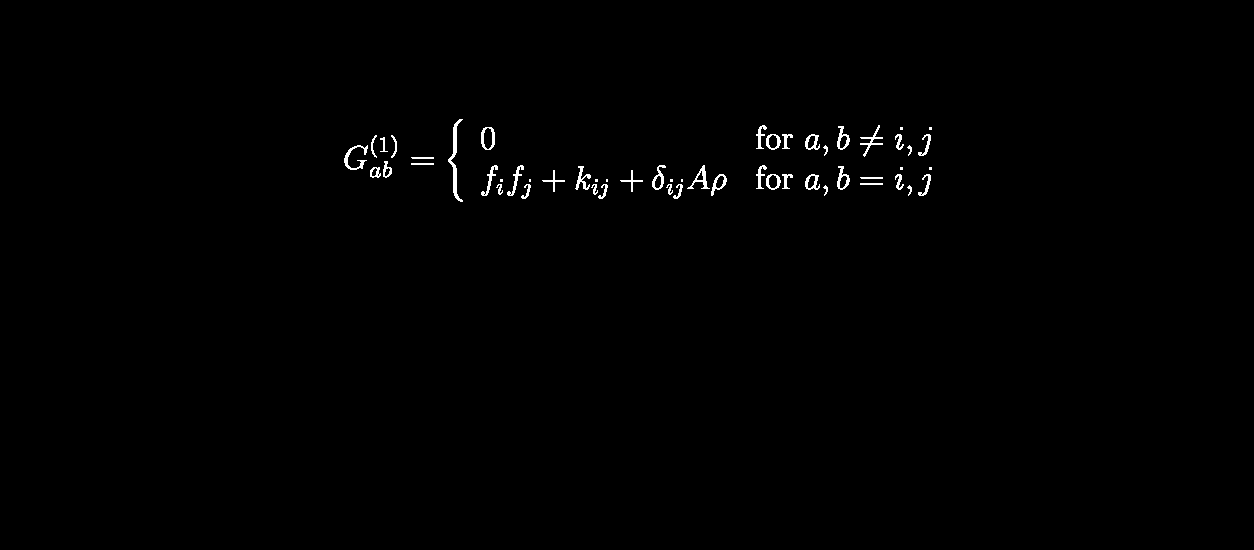

Length of dataset: 10353
7623c5a3e2.png
Label: u_{xx}+u_{yy}+\left[\left(1+{u\over 4}\right)^3\right]_{zz}=0.
Token Idxs: [1, 521, 495, 528, 525, 525, 530, 11, 521, 495, 528, 526, 526, 530, 11, 266, 262, 30, 11, 528, 521, 343, 532, 36, 530, 381, 494, 33, 391, 495, 528, 527, 527, 530, 46, 24, 16, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokens: ['<sos>', 'u', '_', '{', 'x', 'x', '}', '+', 'u', '_', '{', 'y', 'y', '}', '+', '\\left[', '\\left(', '1', '+', '{', 'u', '\\over', ' ', '4', '}', '\\right)', '^', '3', '\\right]', '_', '{', 'z', 'z', '}', 

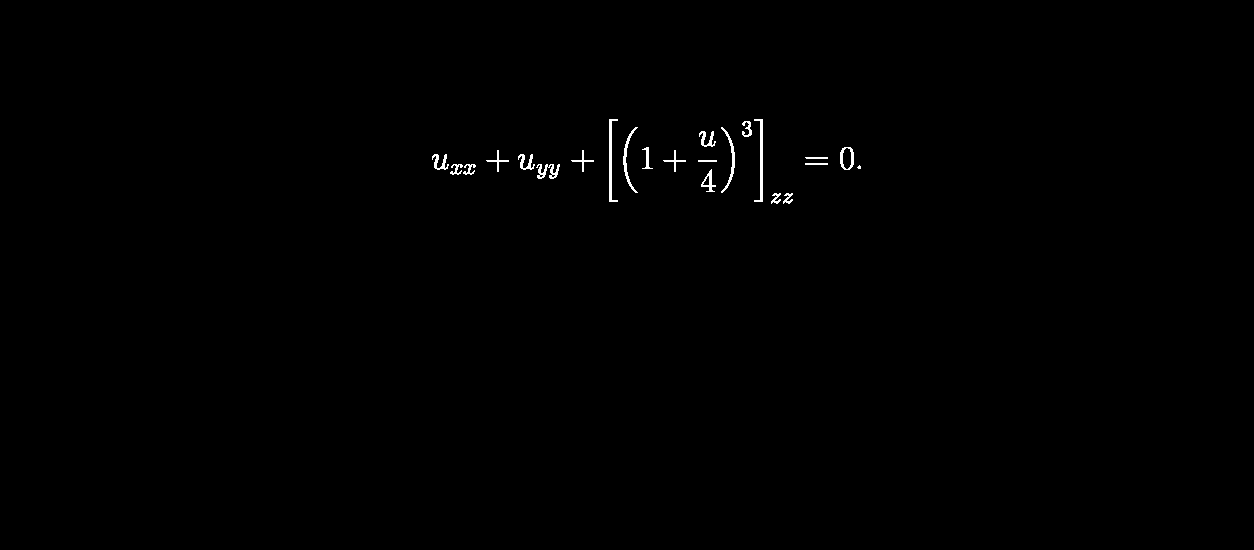

Length of dataset: 10355
64d42f6c28.png
Label: g(p_1,p_2,p_3;l)=g(0)f(p_1,p_2,p_3;l)= e f(p_1,p_2,p_3;l)\,,
Token Idxs: [1, 504, 8, 515, 495, 30, 12, 515, 495, 32, 12, 515, 495, 33, 44, 510, 9, 46, 504, 8, 24, 9, 503, 8, 515, 495, 30, 12, 515, 495, 32, 12, 515, 495, 33, 44, 510, 9, 46, 532, 502, 532, 503, 8, 515, 495, 30, 12, 515, 495, 32, 12, 515, 495, 33, 44, 510, 9, 85, 12, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokens: ['<sos>', 'g', '(', 'p', '_', '1', ',', 'p', '_', '2', ',', 'p', '_', '3', ';', 'l', ')', '=', 'g', '(', '0', ')', 'f', '(', 'p', '_', '1', ',', 'p', '_', '2', ',', 'p', '_', '3', ';', 'l', ')

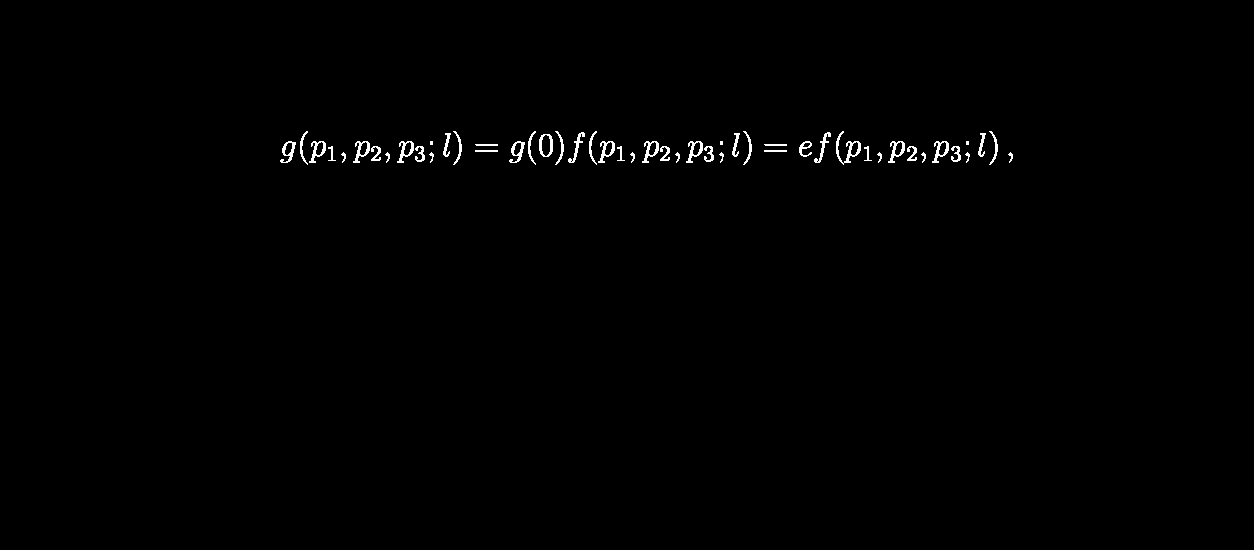

In [5]:
from PIL import Image
import os
from IPython.display import display

datasets = [train_data, validation_data, test_data]

for dataset in datasets:
    # Print length of dataset
    print('Length of dataset: {}'.format(len(dataset)))

    # Get a random number from len(train_data)
    rand_num = np.random.randint(0, len(train_data))

    # Get the image and label from the dataset
    image, label, file_name = train_data[rand_num]

    print(file_name)

    # Convert the tensor to a PIL image
    image_pil = transforms.ToPILImage()(image)

    # Print the label
    print('Label: {}'.format(label))

    # Print the label as tokens
    tokens = latex_vocab.split_string_by_tokens(label, max_token_length)
    print('Token Idxs: {}'.format(tokens))
    print('Tokens: {}'.format([latex_vocab.id2token[id] for id in tokens]))
    print(len(tokens))

    # Show the image in Jupyter notebook
    display(image_pil)


## Train

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
# Model hyperparameters
model = Transformer(
    trg_vocab_size=len(latex_vocab),
    trg_pad_idx=latex_vocab.pad_idx,
    embed_size=1024,
    resnet_type=50,
    num_layers=6,
    forward_expansion=4,
    heads=4,
    dropout=0,
    device=device,
    max_length=200  
).to(device)

# Train the model
train_loss, blue_scores = train(model=model, 
                                model_name='im2latex_all_ns', 
                                train_loader=train_loader, 
                                validation_loader=validation_loader,
                                vocab_obj=latex_vocab,
                                max_token_length=200,
                                num_epochs=10,
                                learning_rate=1e-4, 
                                device=device,
                                print_every=40)

# Plot the training and validation loss
plot_losses_bleu(train_loss, blue_scores)

[Epoch 1 / 6]


## Hyperparameter Optimization

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
import dill

# Define the function that trains and evaluates the model
def train_and_evaluate(hyperparams):
    resnet_type, num_layers, embed_size, heads = hyperparams
    print("Training with hyperparameter:")
    print("Resnet Type: {}".format(resnet_type))
    print("Number of layers: {}".format(num_layers))
    print("Embedding size: {}".format(embed_size))
    print("Number of heads: {}".format(heads))
    print()

    model_name = "resnetType{}_layers{}_embed{}_heads{}".format(resnet_type, num_layers, embed_size, heads)

    # Modify the model definition to use the provided hyperparameters
    model = Transformer(
        trg_vocab_size=len(latex_vocab),
        trg_pad_idx=latex_vocab.pad_idx,
        embed_size=embed_size,
        resnet_type=resnet_type,
        num_layers=num_layers,
        forward_expansion=4,
        heads=heads,
        dropout=0,
        device=device,
        max_length=200  
    ).to(device)

    train(model=model, 
          model_name=model_name, 
          train_loader=train_loader, 
          validation_loader=validation_loader,
          vocab_obj=latex_vocab,
          max_token_length=200,
          num_epochs=3,
          learning_rate=1e-4, 
          device=device,
          print_every=40)
    
    # Evaluate the model on the validation set
    print("Evaluating the model on the test set...")
    bleu_score = evaluate(model, test_loader, latex_vocab, device, max_length=200)
    print("BLEU Score: {}".format(bleu_score))

    # Open the log file and write the evaluation results
    log_filename = model_name + "_log.txt"
    log_path = "./models/" + model_name + "/" + log_filename
    with open(log_path, 'a') as f:
        f.write("Model Name: {}\n".format(model_name))
        f.write("Evaluation on the test set:\n")
        f.write("BLEU Score: {}\n".format(bleu_score))

    # Return the negative BLEU score (since the optimizer tries to minimize the objective)
    return -bleu_score

# Define the hyperparameter search space
search_space = [
    Categorical([18, 34, 50], name='resnet_type'),
    Categorical([1, 3, 6], name='num_layers'),
    Categorical([256, 512, 1024, 2048], name='embed_size'),
    Categorical([4, 8, 16], name='heads'),
]

# Perform Bayesian optimization
from skopt import gp_minimize

# Define a callback function that saves the optimization state after each iteration
def save_result(result, filepath):
    with open(filepath, 'wb') as f:
        dill.dump(result, f)

# Initialize the optimization object with some initial random samples
result = gp_minimize(
    func=train_and_evaluate,
    dimensions=search_space,
    n_calls=50,
    random_state=42,
    callback=lambda res: save_result(res, 'optimization_state.pkl')
)

# Get the best hyperparameters
best_hyperparams = result.x
print("Best hyperparameters: ", best_hyperparams)


## Single Image Eval

cpu


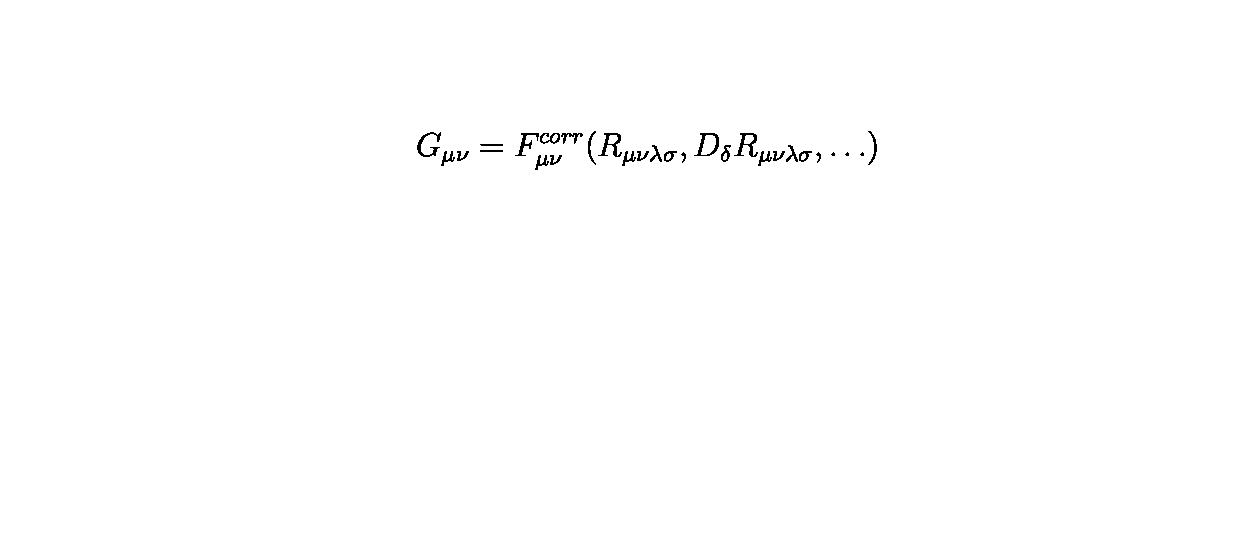

Target Formula: 
G_{\mu\nu}= F_{\mu\nu}^{corr} ( R_{\mu\nu\lambda\sigma},D_{\delta} R_{\mu\nu\lambda\sigma}, \dots)

Predicted Formula 1: 
G_{\mu\nu} = F^{corr}_{\mu\nu} (R_{\mu\nu\lambda\sigma},D_\delta R_{\mu\nu\lambda\sigma},\ldots)
BLEU Score: 0.6905410100184718
Output Length: 48



In [8]:
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image, ImageOps

# Check for CUDA availability and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Model hyperparameters and initialization
model = Transformer(
    trg_vocab_size=len(latex_vocab),
    trg_pad_idx=latex_vocab.pad_idx,
    embed_size=1024,
    resnet_type=50,
    num_layers=6,
    forward_expansion=4,
    heads=4,
    dropout=0,
    device=device,
    max_length=200  
).to(device)

# Load pre-trained model
model.load_state_dict(torch.load('./models/im2latex_all/im2latex_all.pkl', 
                                 map_location=torch.device(device)))

# Load random image from the test set
all_images = os.listdir('processed_data/test_all')
image_name = all_images[np.random.randint(0, len(all_images))]
example_image = Image.open('processed_data/test_all/' + image_name)

# Invert the image
inverted_image = ImageOps.invert(example_image)

# Display the inverted image
display(inverted_image)

# Find the corresponding formula for the selected image
with open('processed_data/test_formulas_all.txt', 'r', encoding='windows-1252') as f:
    for line in f:
        parts = line.strip().split(' ')
        if (parts[0] == image_name):
            ref = ' '.join(parts[1:])
            print("Target Formula: ")
            print(' '.join(parts[1:]))

# Evaluate the model and generate predictions
model.eval()
translated_sentence = translate_sentence(
    model, example_image, latex_vocab, transform, device, k=1, max_length=200
)

# Print predicted formulas and calculate their BLEU scores
for i in range(len(translated_sentence)):
    print("\nPredicted Formula {}: ".format(i+1))
    print("".join(translated_sentence[i]))
    # print(" ".join(translated_sentence[i]), "\n")

    token_idxs = latex_vocab.split_string_by_tokens(ref, max_length=200)
    tokens = [latex_vocab.id2string(idx) for idx in [token_idxs]]
    print("BLEU Score: {}".format(sentence_bleu([translated_sentence[i]], tokens[0])))
    print("Output Length: {}".format(len(translated_sentence[i])))
    print()


## Test Set Eval

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Model hyperparameters
model = Transformer(
    trg_vocab_size=len(latex_vocab),
    trg_pad_idx=latex_vocab.pad_idx,
    embed_size=1024,
    resnet_type=50,
    num_layers=6,
    forward_expansion=4,
    heads=4,
    dropout=0,
    device=device,
    max_length=200  
).to(device)

model.load_state_dict(torch.load('.models\im2latex_all\im2latex_all.pkl', 
                                 map_location=torch.device(device)))
# Evaluate the model on the validation set
print("Evaluating the model on the test set...")
bleu_score = evaluate(model, test_loader, latex_vocab, device, max_length=200)
print("BLEU Score: {}".format(bleu_score))